In [1]:
import pycocotools
import os
import numpy as np
import torch
import torch.utils.data
import cv2
import pandas as pd 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [2]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [3]:
def parse_one_annot(path):
    data = {}
    for i,e in enumerate(os.listdir(path)):
        data_bach = pd.read_csv(os.path.join(path,e))
        data_bach = data_bach.values[0]
        x1 = int((data_bach[0].split(" ")[0]).split(".")[0])
        y1 = int((data_bach[0].split(" ")[1]).split(".")[0])
        x2 = int((data_bach[0].split(" ")[2]).split(".")[0])
        y2 = int((data_bach[0].split(" ")[3]).split(".")[0])
        data[e] = [x1,y1,x2,y2]
    return data

In [4]:
#a = parse_one_annot("Label")
#a['0.csv']

In [5]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, image, label, transforms=None):
        self.image = image
        self.transforms = transforms
        self.imgs = sorted(os.listdir(image))
        self.label =  parse_one_annot(label)
    
    def __getitem__(self, idx):
            # load images and bounding boxes
        img_path = os.path.join(self.image, self.imgs[idx])
        img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        box_list = self.label[self.imgs[idx].split(".")[0]+".csv"]
        box_list = np.expand_dims(box_list, axis=0)
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
            # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
            # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [6]:
dataset = Dataset("Image","Label")
dataset.__getitem__(0)[0].shape

(745, 500, 3)

In [7]:
def get_model(num_classes):
        # load an object detection model pre-trained on COCO
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)# get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

In [8]:
def get_transform(train):
    transforms = []
        # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
# use our dataset and defined transformationsdataset
dataset = Dataset("Image","Label",get_transform(train=True))
dataset_test = Dataset("Image","Label",get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
a = int(len(dataset)*4/10)
print(a)
b =int(len(dataset)/2 - a)
print(b)
dataset = torch.utils.data.Subset(dataset, indices[:a])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-b:])                       

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False,num_workers=0,collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0,collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

3343
836
We have: 8359 examples, 3343 are training and 836 testing


In [10]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 355, 550])

In [11]:
torch.cuda.is_available()

True

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epoch
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [25]:
# let's train it for 10 epochs
num_epochs = 1
for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,print_freq=10)# update the learning rate
    lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/3343]  eta: 3:20:50  lr: 0.000010  loss: 0.0804 (0.0804)  loss_classifier: 0.0304 (0.0304)  loss_box_reg: 0.0490 (0.0490)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 3.6047  data: 0.0080  max mem: 1734
Epoch: [0]  [  10/3343]  eta: 2:27:11  lr: 0.000060  loss: 0.0447 (0.0458)  loss_classifier: 0.0111 (0.0127)  loss_box_reg: 0.0353 (0.0325)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.6498  data: 0.0171  max mem: 1765
Epoch: [0]  [  20/3343]  eta: 1:28:14  lr: 0.000110  loss: 0.0375 (0.0455)  loss_classifier: 0.0109 (0.0138)  loss_box_reg: 0.0223 (0.0310)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0005)  time: 1.4926  data: 0.0116  max mem: 1819
Epoch: [0]  [  30/3343]  eta: 1:07:21  lr: 0.000160  loss: 0.0400 (0.0560)  loss_classifier: 0.0110 (0.0193)  loss_box_reg: 0.0254 (0.0354)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0009)  time: 0.4334  data: 0.0058  max me

Epoch: [0]  [ 330/3343]  eta: 0:25:41  lr: 0.001658  loss: 0.0566 (0.0509)  loss_classifier: 0.0109 (0.0178)  loss_box_reg: 0.0364 (0.0318)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 0.4633  data: 0.0131  max mem: 1821
Epoch: [0]  [ 340/3343]  eta: 0:25:31  lr: 0.001708  loss: 0.0460 (0.0510)  loss_classifier: 0.0121 (0.0179)  loss_box_reg: 0.0282 (0.0318)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0007)  time: 0.4503  data: 0.0116  max mem: 1821
Epoch: [0]  [ 350/3343]  eta: 0:25:22  lr: 0.001758  loss: 0.0418 (0.0509)  loss_classifier: 0.0139 (0.0179)  loss_box_reg: 0.0266 (0.0316)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.4601  data: 0.0151  max mem: 1821
Epoch: [0]  [ 360/3343]  eta: 0:25:12  lr: 0.001808  loss: 0.0375 (0.0507)  loss_classifier: 0.0133 (0.0178)  loss_box_reg: 0.0223 (0.0315)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0003 (0.0007)  time: 0.4538  data: 0.0127  max me

Epoch: [0]  [ 660/3343]  eta: 0:21:44  lr: 0.003307  loss: 0.0529 (0.0512)  loss_classifier: 0.0146 (0.0183)  loss_box_reg: 0.0296 (0.0315)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.4538  data: 0.0117  max mem: 1822
Epoch: [0]  [ 670/3343]  eta: 0:21:38  lr: 0.003357  loss: 0.0477 (0.0512)  loss_classifier: 0.0124 (0.0182)  loss_box_reg: 0.0310 (0.0315)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0007)  time: 0.4676  data: 0.0137  max mem: 1822
Epoch: [0]  [ 680/3343]  eta: 0:21:33  lr: 0.003407  loss: 0.0477 (0.0513)  loss_classifier: 0.0122 (0.0183)  loss_box_reg: 0.0328 (0.0316)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 0.4703  data: 0.0190  max mem: 1822
Epoch: [0]  [ 690/3343]  eta: 0:21:27  lr: 0.003457  loss: 0.0478 (0.0513)  loss_classifier: 0.0125 (0.0183)  loss_box_reg: 0.0328 (0.0316)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0007)  time: 0.4600  data: 0.0120  max me

Epoch: [0]  [ 990/3343]  eta: 0:18:47  lr: 0.004955  loss: 0.0448 (0.0529)  loss_classifier: 0.0128 (0.0188)  loss_box_reg: 0.0309 (0.0326)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0008)  time: 0.4684  data: 0.0116  max mem: 1822
Epoch: [0]  [1000/3343]  eta: 0:18:41  lr: 0.005000  loss: 0.0492 (0.0529)  loss_classifier: 0.0120 (0.0187)  loss_box_reg: 0.0319 (0.0327)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0008)  time: 0.4604  data: 0.0126  max mem: 1822
Epoch: [0]  [1010/3343]  eta: 0:18:37  lr: 0.005000  loss: 0.0493 (0.0529)  loss_classifier: 0.0137 (0.0187)  loss_box_reg: 0.0345 (0.0327)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0004 (0.0008)  time: 0.4613  data: 0.0150  max mem: 1822
Epoch: [0]  [1020/3343]  eta: 0:18:31  lr: 0.005000  loss: 0.0499 (0.0530)  loss_classifier: 0.0140 (0.0187)  loss_box_reg: 0.0367 (0.0328)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0003 (0.0008)  time: 0.4624  data: 0.0133  max me

Epoch: [0]  [1320/3343]  eta: 0:16:04  lr: 0.005000  loss: 0.0627 (0.0549)  loss_classifier: 0.0187 (0.0191)  loss_box_reg: 0.0396 (0.0342)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 0.4519  data: 0.0135  max mem: 1822
Epoch: [0]  [1330/3343]  eta: 0:15:59  lr: 0.005000  loss: 0.0446 (0.0548)  loss_classifier: 0.0142 (0.0191)  loss_box_reg: 0.0263 (0.0341)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 0.4450  data: 0.0110  max mem: 1822
Epoch: [0]  [1340/3343]  eta: 0:15:54  lr: 0.005000  loss: 0.0446 (0.0548)  loss_classifier: 0.0154 (0.0191)  loss_box_reg: 0.0245 (0.0341)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0008)  time: 0.4572  data: 0.0139  max mem: 1822
Epoch: [0]  [1350/3343]  eta: 0:15:49  lr: 0.005000  loss: 0.0591 (0.0549)  loss_classifier: 0.0196 (0.0191)  loss_box_reg: 0.0357 (0.0341)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0004 (0.0008)  time: 0.4640  data: 0.0156  max me

Epoch: [0]  [1650/3343]  eta: 0:13:22  lr: 0.005000  loss: 0.0537 (0.0558)  loss_classifier: 0.0153 (0.0193)  loss_box_reg: 0.0423 (0.0349)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0009)  time: 0.4508  data: 0.0156  max mem: 1822
Epoch: [0]  [1660/3343]  eta: 0:13:17  lr: 0.005000  loss: 0.0615 (0.0558)  loss_classifier: 0.0157 (0.0193)  loss_box_reg: 0.0448 (0.0349)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4623  data: 0.0149  max mem: 1822
Epoch: [0]  [1670/3343]  eta: 0:13:12  lr: 0.005000  loss: 0.0535 (0.0558)  loss_classifier: 0.0150 (0.0192)  loss_box_reg: 0.0388 (0.0349)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.4584  data: 0.0138  max mem: 1822
Epoch: [0]  [1680/3343]  eta: 0:13:07  lr: 0.005000  loss: 0.0505 (0.0557)  loss_classifier: 0.0141 (0.0192)  loss_box_reg: 0.0359 (0.0349)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0009)  time: 0.4730  data: 0.0153  max me

Epoch: [0]  [1980/3343]  eta: 0:10:43  lr: 0.005000  loss: 0.0458 (0.0561)  loss_classifier: 0.0134 (0.0193)  loss_box_reg: 0.0320 (0.0352)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4722  data: 0.0156  max mem: 1822
Epoch: [0]  [1990/3343]  eta: 0:10:39  lr: 0.005000  loss: 0.0471 (0.0561)  loss_classifier: 0.0143 (0.0193)  loss_box_reg: 0.0320 (0.0353)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 0.4788  data: 0.0194  max mem: 1822
Epoch: [0]  [2000/3343]  eta: 0:10:34  lr: 0.005000  loss: 0.0553 (0.0564)  loss_classifier: 0.0154 (0.0194)  loss_box_reg: 0.0375 (0.0353)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4725  data: 0.0181  max mem: 1822
Epoch: [0]  [2010/3343]  eta: 0:10:29  lr: 0.005000  loss: 0.0464 (0.0563)  loss_classifier: 0.0167 (0.0194)  loss_box_reg: 0.0298 (0.0353)  loss_objectness: 0.0009 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0009)  time: 0.4590  data: 0.0137  max me

Epoch: [0]  [2310/3343]  eta: 0:08:06  lr: 0.005000  loss: 0.0466 (0.0575)  loss_classifier: 0.0119 (0.0200)  loss_box_reg: 0.0302 (0.0358)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0002 (0.0009)  time: 0.4595  data: 0.0121  max mem: 1822
Epoch: [0]  [2320/3343]  eta: 0:08:02  lr: 0.005000  loss: 0.0480 (0.0575)  loss_classifier: 0.0144 (0.0200)  loss_box_reg: 0.0291 (0.0358)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4630  data: 0.0103  max mem: 1822
Epoch: [0]  [2330/3343]  eta: 0:07:57  lr: 0.005000  loss: 0.0621 (0.0577)  loss_classifier: 0.0172 (0.0201)  loss_box_reg: 0.0332 (0.0359)  loss_objectness: 0.0015 (0.0008)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 0.4669  data: 0.0093  max mem: 1822
Epoch: [0]  [2340/3343]  eta: 0:07:52  lr: 0.005000  loss: 0.0814 (0.0578)  loss_classifier: 0.0165 (0.0201)  loss_box_reg: 0.0473 (0.0359)  loss_objectness: 0.0014 (0.0008)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 0.4601  data: 0.0119  max me

Epoch: [0]  [2640/3343]  eta: 0:05:30  lr: 0.005000  loss: 0.0505 (0.0581)  loss_classifier: 0.0132 (0.0202)  loss_box_reg: 0.0302 (0.0362)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4687  data: 0.0127  max mem: 1822
Epoch: [0]  [2650/3343]  eta: 0:05:25  lr: 0.005000  loss: 0.0505 (0.0581)  loss_classifier: 0.0154 (0.0202)  loss_box_reg: 0.0327 (0.0362)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4570  data: 0.0125  max mem: 1822
Epoch: [0]  [2660/3343]  eta: 0:05:21  lr: 0.005000  loss: 0.0485 (0.0581)  loss_classifier: 0.0151 (0.0202)  loss_box_reg: 0.0316 (0.0362)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4531  data: 0.0112  max mem: 1822
Epoch: [0]  [2670/3343]  eta: 0:05:16  lr: 0.005000  loss: 0.0510 (0.0580)  loss_classifier: 0.0128 (0.0202)  loss_box_reg: 0.0322 (0.0362)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 0.4630  data: 0.0107  max me

Epoch: [0]  [2970/3343]  eta: 0:02:55  lr: 0.005000  loss: 0.0491 (0.0579)  loss_classifier: 0.0139 (0.0201)  loss_box_reg: 0.0301 (0.0361)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.4772  data: 0.0141  max mem: 1822
Epoch: [0]  [2980/3343]  eta: 0:02:50  lr: 0.005000  loss: 0.0557 (0.0579)  loss_classifier: 0.0164 (0.0201)  loss_box_reg: 0.0343 (0.0361)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.4763  data: 0.0141  max mem: 1822
Epoch: [0]  [2990/3343]  eta: 0:02:45  lr: 0.005000  loss: 0.0563 (0.0580)  loss_classifier: 0.0170 (0.0201)  loss_box_reg: 0.0368 (0.0361)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0005 (0.0009)  time: 0.4819  data: 0.0173  max mem: 1822
Epoch: [0]  [3000/3343]  eta: 0:02:41  lr: 0.005000  loss: 0.0581 (0.0580)  loss_classifier: 0.0165 (0.0202)  loss_box_reg: 0.0368 (0.0362)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 0.4783  data: 0.0161  max me

Epoch: [0]  [3300/3343]  eta: 0:00:20  lr: 0.005000  loss: 0.0604 (0.0579)  loss_classifier: 0.0174 (0.0200)  loss_box_reg: 0.0343 (0.0362)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.5059  data: 0.0206  max mem: 1822
Epoch: [0]  [3310/3343]  eta: 0:00:15  lr: 0.005000  loss: 0.0504 (0.0579)  loss_classifier: 0.0134 (0.0200)  loss_box_reg: 0.0296 (0.0362)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0009)  time: 0.5468  data: 0.0290  max mem: 1822
Epoch: [0]  [3320/3343]  eta: 0:00:10  lr: 0.005000  loss: 0.0527 (0.0579)  loss_classifier: 0.0119 (0.0200)  loss_box_reg: 0.0348 (0.0362)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0004 (0.0009)  time: 0.5891  data: 0.0432  max mem: 1822
Epoch: [0]  [3330/3343]  eta: 0:00:06  lr: 0.005000  loss: 0.0527 (0.0579)  loss_classifier: 0.0169 (0.0200)  loss_box_reg: 0.0352 (0.0362)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0003 (0.0009)  time: 0.5961  data: 0.0478  max me

In [26]:
torch.save(model.state_dict(), "model")

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import torchvision.models as models
import time

def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)# get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

print(torch.cuda.is_available())
loaded_model = get_model(num_classes = 2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loaded_model.to(device)
loaded_model.load_state_dict(torch.load("model"))

True


<All keys matched successfully>

0.19448041915893555


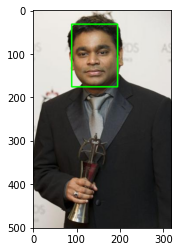

In [49]:
image = cv2.imread("Image/46.jpg")
img = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = torch.tensor(img.transpose(2,1,0)).cuda()

#put the model in evaluation mode
loaded_model.eval()

with torch.no_grad():
    a = time.time()
    prediction = loaded_model([img])
    b = time.time()
    print(b-a)
    
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),decimals= 4)
    cv2.rectangle(image, (int(boxes[1]), int(boxes[0])), (int(boxes[3]), int(boxes[2])), (0, 255, 0), 2, cv2.LINE_AA)
    break
         
plt.figure()        
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))